In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

#Load Data

DRdata = pd.read_csv('../Data/Inhibition_compiled.csv')


In [2]:
#Imported paramters and GFP-CFU Mapping

popti=np.array([0.85343273, 3.91359871, 2.50848446])

#log cfu to log gfp mapping
def lctolg(x,a,b,c):
    return a*np.tanh((x-b)/c)

#lof gfp to log cfu mapping
def lgtolc(x,a,b,c):
    return (c/2)*np.log((1+x/a)/(1-x/a))+b

parami=np.array([4.00229685, 0.8844725, 3.064446])


In [3]:
x=np.arange(0,10,.01)

In [4]:
conditions = DRdata['Condition'].unique()
timepoints = DRdata['Time'].unique()

#Select the additional inhibitions conditions of birth-dirth process

selected_conditions = [conditions[1], conditions[2]]

condition_titles = { 'CM100' : "Low Inhibition, CM100", 'CM250' : 'High Inhibition, CM250'}

#Fit the data at each timepoint to a Gaussian Mixture Model with 2 components and store the means, stds and weights


means_lst = np.zeros((2, 5, 2))
std_lst = np.zeros((2, 5, 2))
weights_lst = np.zeros((2,5, 2))
tmeans_lst = np.zeros((2, 5, 2))
tstd_lst = np.zeros((2, 5, 2))
tweights_lst = np.zeros((2,5, 2))


timepoint_averages = np.zeros((len(selected_conditions), len(timepoints)))
ttimepoint_averages = np.zeros((len(selected_conditions), len(timepoints)))

for i, condition in enumerate(selected_conditions):
    for j, timepoint in enumerate(timepoints):
        
        subset_v = DRdata[(DRdata['Condition'] == condition) & (DRdata['Time'] == timepoint)]['Green'].values.reshape(-1, 1)
        subset = np.log10(subset_v)
        
        timepoint_averages[i, j] = np.mean(subset)
        
        subset=lgtolc(subset,*parami)
        
        
        ttimepoint_averages[i, j] = np.mean(subset)
        

        gmm = GaussianMixture(n_components=2, random_state=0)


        gmm.fit(subset)
        
#         plot the histograms of data and compare to the components        
#         plt.figure()        
#         tn,tbins,tpatches=plt.hist(subset,40, density=True,label='log(GFP) Data')
#         plt.plot(x,np.exp(gmm.score_samples(x.reshape(-1, 1))),label='fit sim')
#         plt.legend()

        

        
        sorted_indices = np.argsort(gmm.means_.flatten())
        means_lst[i, j, :] = gmm.means_.reshape(2,)[sorted_indices]
        std_lst[i, j, :] = np.sqrt(gmm.covariances_).reshape(2,)[sorted_indices]
        weights_lst[i, j, :] = gmm.weights_.reshape(2,)[sorted_indices]
        
        tmeans_lst[i,j,:]=means_lst[i,j,:]
        tstd_lst[i,j,:]=std_lst[i,j,:]
        tweights_lst[i,j,:]=weights_lst[i,j,:]
        
        means_lst[i,j,:]=lctolg(means_lst[i,j,:], *parami)
       # std_lst[i,j,:]=lctolg(std_lst[i,j,:], *parami)



/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_3997/915181638.py:11: RuntimeWarning: invalid value encountered in log
  return (c/2)*np.log((1+x/a)/(1-x/a))+b


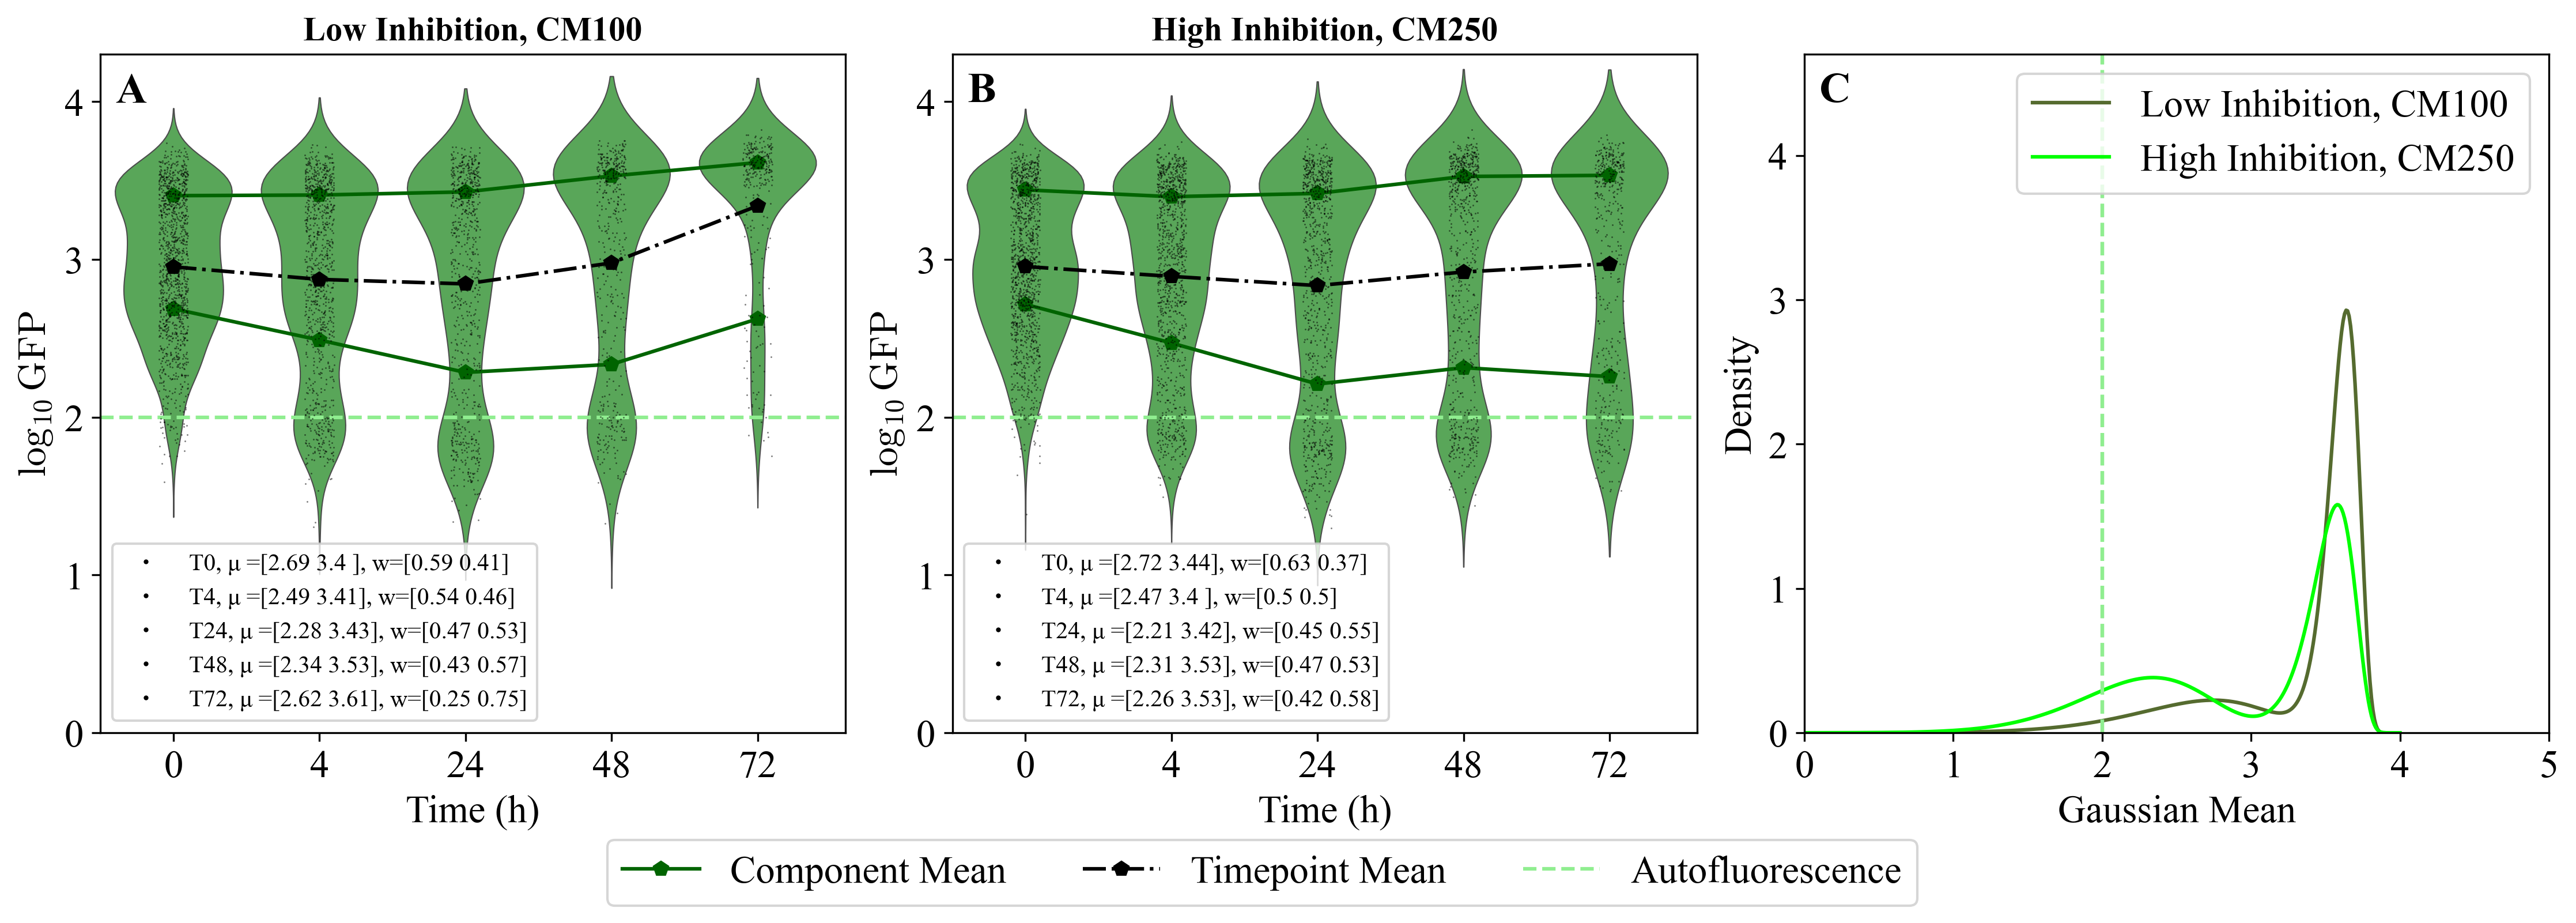

In [5]:
Times_p = [0, 4, 24, 48, 72]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=False, sharey=False)

#plots showing the GFP data along with means and weights of the transformed GMM fits.

for q, condition in enumerate(selected_conditions):
    
    sns.violinplot(x='Time', y=np.log10(DRdata[DRdata['Condition'] == condition]['Green']), 
                   data=DRdata[DRdata['Condition'] == condition], ax=axes[q], inner=None, 
                   color='limegreen', saturation=0.5, linewidth=0.5, scale='width')
    
    sns.stripplot(x='Time', y=np.log10(DRdata[DRdata['Condition'] == condition]['Green']), 
                   data=DRdata[DRdata['Condition'] == condition], ax=axes[q], 
                  color='black', size = 0.7, alpha = 0.5)
    
    axes[q].plot(range(len(Times_p)), means_lst[q, :, 0], marker='p', linestyle='-', 
                     color='darkgreen', zorder=2, label="Component Mean")
    axes[q].plot(range(len(Times_p)), means_lst[q, :, 1],  marker='p', linestyle='-', 
                     color='darkgreen', zorder=2)
    
    axes[q].plot(range(len(timepoints)), timepoint_averages[q], marker='p', linestyle='-.', 
                 color='black', label='Timepoint Mean')
    axes[q].axhline(y=2, color='lightgreen', linestyle='--', label="Autofluorescence")
    axes[q].set_title(condition_titles[condition], fontsize = 14,  fontweight = 'bold')
    axes[q].set_xticks(range(len(Times_p)))
    axes[q].set_xticklabels(Times_p, fontsize=16)
    axes[q].set_yticks(np.arange(0,5, 1))
    axes[q].set_yticklabels(np.arange(0, 5, 1), fontsize=16)
    axes[q].set_xlim(-0.5,4.6)
    axes[q].set_ylim(0,4.3)
    axes[q].legend(loc='lower left', fontsize=10)
    axes[q].set_ylabel(r'$\log_{10} \mathrm{GFP}$', fontsize=16)
    

    

    axes[q].set_xlabel('Time (h)', fontsize=16)
        
    
    legend_handles = []
    legend_labels = []
    for s, time in enumerate(Times_p):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markersize=3, 
                                         markerfacecolor='black'))
        legend_labels.append(f'T{time}, μ ={np.round(means_lst[q, s, :], 2)}, w={np.round(weights_lst[q, s, :], 2)}')

    axes[q].legend(handles=legend_handles, labels=legend_labels, loc='lower left', fontsize=10, title="")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize=16, ncol = 3, bbox_to_anchor=(0.75, -0.08))



x = np.linspace(0, 5, 500)

colors = {
    'CM100': 'darkolivegreen',  
    'CM250': 'lime'}


#plots for PDFs for the reverse transformed GMM

for i, condition in enumerate(selected_conditions):

    low_mean = tmeans_lst[i, 4, 0]
    low_std = tstd_lst[i, 4, 0]
    low_weight = tweights_lst[i, 4, 0]
    low_pdf = norm.pdf(lgtolc(x,*parami), low_mean, low_std) * low_weight * (parami[2]/parami[0])/(1-(x/parami[0])**2)

    high_mean = tmeans_lst[i, 4, 1]
    high_std = tstd_lst[i, 4, 1]
    high_weight = tweights_lst[i, 4, 1]
    high_pdf = norm.pdf(lgtolc(x,*parami), high_mean, high_std) * high_weight*(parami[2]/parami[0])/(1-(x/parami[0])**2)

    full_pdf = low_pdf + high_pdf
    
    axes[2].plot(x, full_pdf, color = colors[condition], ls = '-',  label = f'{condition_titles[condition]}')
    axes[2].legend(loc = 'upper right', fontsize = 16)
    axes[2].axvline(x=2, color='lightgreen', linestyle='--')


axes[2].set_ylim(0, 4.7)
axes[2].set_xlim(0, 5)
axes[2].set_xlabel('Gaussian Mean', fontsize=16)
axes[2].set_ylabel('Density', fontsize=16)

axes[0].text(0.02,.93,'A',fontsize=18,weight='bold',transform=axes[0].transAxes)
axes[1].text(0.02,.93,'B',fontsize=18,weight='bold',transform=axes[1].transAxes)
axes[2].text(0.02,.93,'C',fontsize=18,weight='bold',transform=axes[2].transAxes)

axes[2].set_yticks(range(0, 5, 1))

axes[2].tick_params(axis='both', which='major', labelsize=16)  

plt.tight_layout(w_pad = 1.0)

plt.savefig("../Figures/SIFigure_DR.pdf", dpi = 300, bbox_inches='tight')

plt.show()


In [6]:
#print all the means,stds and weights values for both conditions

print(
"""
\\begin{center}
    \\begin{tabular}{| l | l | l | l | l | l | l | l |}
    \hline
    Condition & Time & Mean 1 & Mean 2 & Std 1 & Std 2 & Weight 1 & Weight 2 \\\\ \hline
"""
)
for i, condition in enumerate(selected_conditions):
    for j, timepoint in enumerate(timepoints):
        print(f"{condition} & {timepoint} & {tmeans_lst[i, j, 0]:.2f} & {tmeans_lst[i, j, 1]:.2f} & {tstd_lst[i, j, 0]:.2f} & {tstd_lst[i, j, 1]:.2f} & {tweights_lst[i, j, 0]:.2f} & {tweights_lst[i, j, 1]:.2f} \\\\ \hline")

print(
"""
    \hline
    \end{tabular}
\end{center}
""")


\begin{center}
    \begin{tabular}{| l | l | l | l | l | l | l | l |}
    \hline
    Condition & Time & Mean 1 & Mean 2 & Std 1 & Std 2 & Weight 1 & Weight 2 \\ \hline

CM100 & T0 & 3.38 & 4.74 & 0.46 & 0.48 & 0.59 & 0.41 \\ \hline
CM100 & T4 & 3.12 & 4.75 & 0.56 & 0.51 & 0.54 & 0.46 \\ \hline
CM100 & T24 & 2.87 & 4.81 & 0.57 & 0.53 & 0.47 & 0.53 \\ \hline
CM100 & T48 & 2.93 & 5.13 & 0.58 & 0.52 & 0.43 & 0.57 \\ \hline
CM100 & T72 & 3.29 & 5.45 & 0.62 & 0.44 & 0.25 & 0.75 \\ \hline
CM250 & T0 & 3.42 & 4.85 & 0.48 & 0.46 & 0.63 & 0.37 \\ \hline
CM250 & T4 & 3.09 & 4.72 & 0.55 & 0.56 & 0.50 & 0.50 \\ \hline
CM250 & T24 & 2.79 & 4.78 & 0.53 & 0.58 & 0.45 & 0.55 \\ \hline
CM250 & T48 & 2.91 & 5.12 & 0.57 & 0.51 & 0.47 & 0.53 \\ \hline
CM250 & T72 & 2.84 & 5.14 & 0.49 & 0.54 & 0.42 & 0.58 \\ \hline

    \hline
    \end{tabular}
\end{center}

